# DL thon Baseline code

In [5]:
import os
import re
import csv

import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd

from sklearn.preprocessing import LabelEncoder

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

## 1. 데이터 확인

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3950 entries, 0 to 3949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           3950 non-null   int64 
 1   class         3950 non-null   object
 2   conversation  3950 non-null   object
dtypes: int64(1), object(2)
memory usage: 92.7+ KB
None


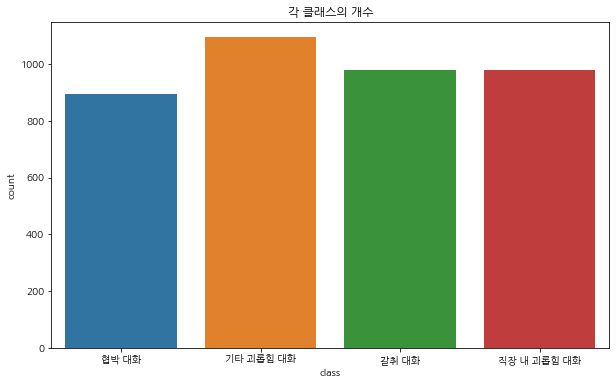

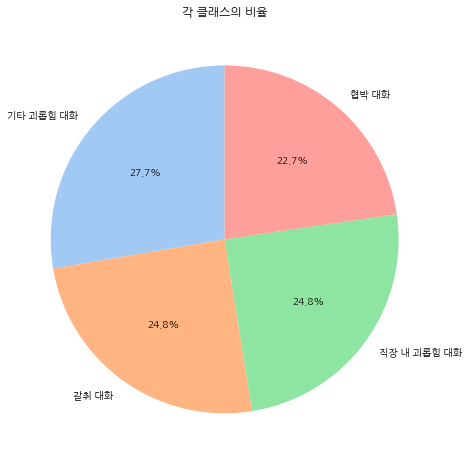

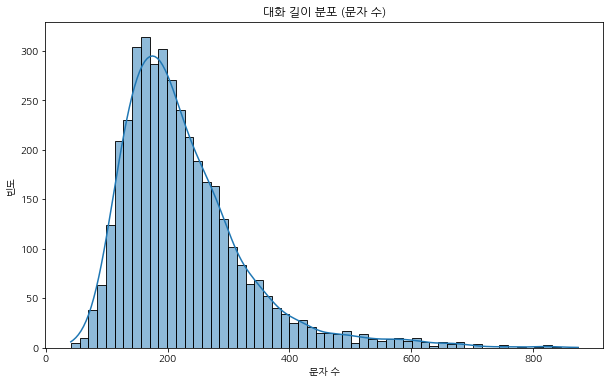

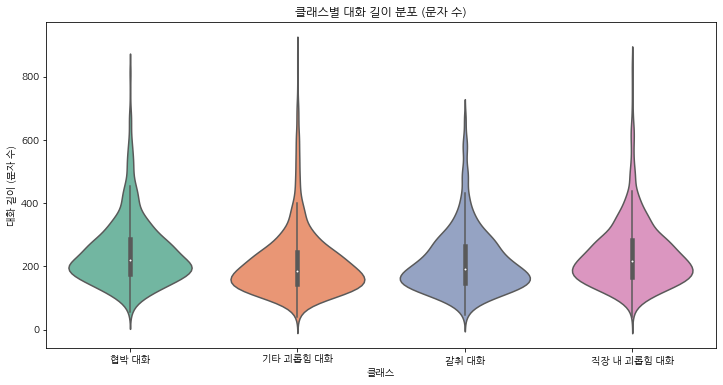

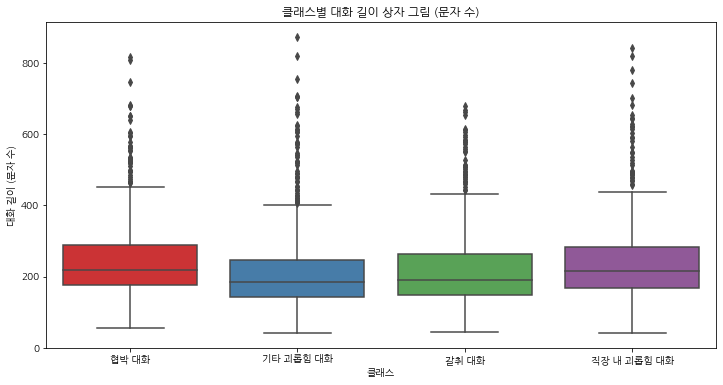

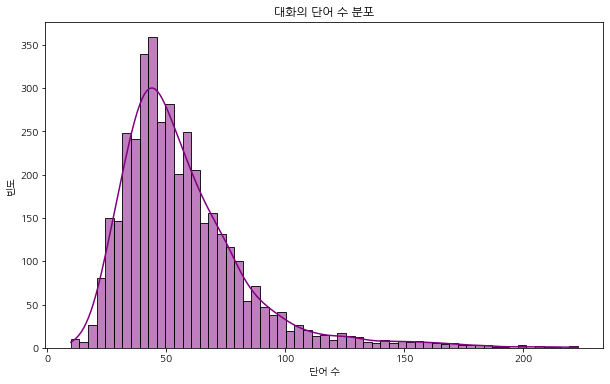

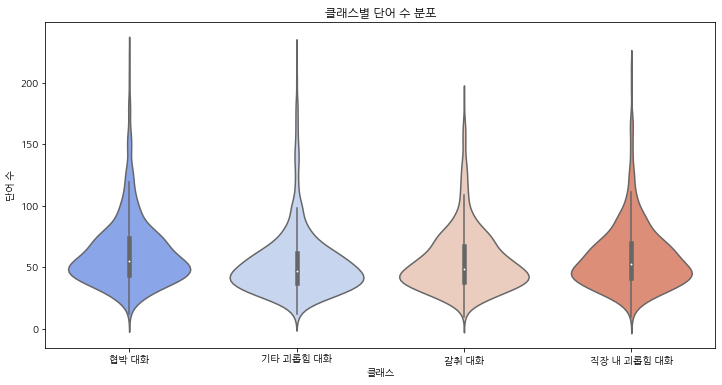

In [3]:


# 한글 폰트 설정 (여기서는 'NanumGothic' 폰트를 사용)
plt.rcParams['font.family'] = 'NanumGothic'

# 데이터 경로 설정 (클론한 저장소의 파일 경로)
data_path = './DKTC/data'

# 데이터 파일 읽기 (데이터 파일 이름을 확인하고 수정)
train_data = pd.read_csv(os.path.join(data_path, 'train.csv'))

# 데이터 기본 정보 확인
print("Train Data Info:")
print(train_data.info())  # 데이터 타입, 결측치 확인

# 1. 'class' 컬럼의 분포 확인
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=train_data)
plt.title('각 클래스의 개수')
plt.show()

# 2. 'class' 컬럼의 비율을 Pie Chart로 시각화
plt.figure(figsize=(8, 8))
train_data['class'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('각 클래스의 비율')
plt.ylabel('')  # Y-label 제거
plt.show()

# 3. 'conversation' 텍스트의 길이 분포 확인 (각 문장의 문자 수)
train_data['text_length'] = train_data['conversation'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(train_data['text_length'], kde=True)
plt.title('대화 길이 분포 (문자 수)')
plt.xlabel('문자 수')
plt.ylabel('빈도')
plt.show()

# 4. 'class'별로 'conversation' 길이 분포 확인 (Violin Plot)
plt.figure(figsize=(12, 6))
sns.violinplot(x='class', y='text_length', data=train_data, palette='Set2')
plt.title('클래스별 대화 길이 분포 (문자 수)')
plt.xlabel('클래스')
plt.ylabel('대화 길이 (문자 수)')
plt.show()

# 5. 'class'별로 'conversation' 길이 상자 그림(Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='class', y='text_length', data=train_data, palette='Set1')
plt.title('클래스별 대화 길이 상자 그림 (문자 수)')
plt.xlabel('클래스')
plt.ylabel('대화 길이 (문자 수)')
plt.show()

# 6. 'class'별로 대화 내용의 단어 수 분포 확인
train_data['word_count'] = train_data['conversation'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(train_data['word_count'], kde=True, color='purple')
plt.title('대화의 단어 수 분포')
plt.xlabel('단어 수')
plt.ylabel('빈도')
plt.show()

# 7. 'class'별로 단어 수 분포 확인 (Violin Plot)
plt.figure(figsize=(12, 6))
sns.violinplot(x='class', y='word_count', data=train_data, palette='coolwarm')
plt.title('클래스별 단어 수 분포')
plt.xlabel('클래스')
plt.ylabel('단어 수')
plt.show()

## 2. [합성 데이터] 생성

## 3. 데이터 전처리

### 범주형 데이터 인코딩

In [12]:
data_path = './DKTC/data'

train_data = pd.read_csv(os.path.join(data_path, 'train.csv'))
test_data = pd.read_json(os.path.join(data_path, 'test.json'))

label_encoder = LabelEncoder()

# 범주형 데이터 인코딩 적용
for column in train_data.select_dtypes(include=['object']).columns:
    train_data[column + '_encoded'] = label_encoder.fit_transform(train_data[column])

print(train_data.head())

   idx      class                                       conversation  \
0    0      협박 대화  지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...   
1    1      협박 대화  길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...   
2    2  기타 괴롭힘 대화  너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...   
3    3      갈취 대화  어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...   
4    4      갈취 대화  저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...   

   class_encoded  conversation_encoded  
0              3                  3577  
1              3                   172  
2              1                   559  
3              0                  2462  
4              0                  3451  


### 불용어 제거 (optional)

In [23]:
def load_data(train_data, test_data, num_words=num_words):
    # 데이터프레임의 열 이름을 확인한 후 변경
    train_data.drop_duplicates(subset=['conversation'], inplace=True)  # 'document' 대신 'conversation'
    train_data = train_data.dropna(how='any')
    
    # test_data에서 사용할 열을 결정 (여기서는 't_000'을 사용한다고 가정)
    test_data.drop_duplicates(subset=['t_000'], inplace=True)  # 'document' 대신 't_000'
    test_data = test_data.dropna(how='any')
    
    X_train = []
    for sentence in train_data['conversation']:  # 'document' 대신 'conversation'
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if word not in stopwords]  # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['t_000']:  # 'document' 대신 't_000'
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if word not in stopwords]  # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000 - 4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word: index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['class'])), X_test, np.array(list(test_data['t_000'])), word_to_index


In [24]:
print(train_data.columns)  # train_data의 열 이름 확인
print(test_data.columns)   # test_data의 열 이름 확인


Index(['idx', 'class', 'conversation', 'class_encoded',
       'conversation_encoded'],
      dtype='object')
Index(['t_000', 't_001', 't_002', 't_003', 't_004', 't_005', 't_006', 't_007',
       't_008', 't_009',
       ...
       't_490', 't_491', 't_492', 't_493', 't_494', 't_495', 't_496', 't_497',
       't_498', 't_499'],
      dtype='object', length=500)


In [25]:
# Load the data first
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

# Create index_to_word mapping after loading the data
index_to_word = {index: word for word, index in word_to_index.items()}

# Print a sample of the mapping
print("Sample index to word mapping:")
print(dict(list(index_to_word.items())[:10]))  # Show first 10 mappings


Sample index to word mapping:
{3: '', 4: '.', 5: '?', 6: '하', 7: '야', 8: '고', 9: '어', 10: '거', 11: '지', 12: '나'}


In [26]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 데이터 분석 및 가공

In [27]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  103.79932414868729
문장길이 최대 :  394
문장길이 표준편차 :  46.74688097348699
pad_sequences maxlen :  197
전체 문장의 0.952950350922797%가 maxlen 설정값 이내에 포함됩니다. 


In [28]:
# 처음 몇 개 인덱스에 대해 사전 정의 해주어야 함.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

In [29]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(3846, 197)


## 4. 모델링

### 예시로 1-d cnn 사용

In [35]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 8  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(4, activation='softmax')) # 4개 카테고리, softmax 사용

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 8)           80000     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          912       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

In [37]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (3846, 197)
y_train shape: (3846,)


In [42]:
from sklearn.preprocessing import LabelEncoder

# 문자열 레이블을 정수로 인코딩
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# validation 데이터도 같은 방식으로 인코딩
y_val_encoded = label_encoder.transform(y_val)

# 인코딩된 y 데이터로 모델 훈련
history = model_cnn.fit(X_train,
                         y_train_encoded,
                         epochs=epochs,
                         batch_size=256,
                         validation_data=(x_val, y_val_encoded),
                         verbose=1)


Epoch 1/5
16/16 [==============================] - 51s 29ms/step - loss: 1.3854 - accuracy: 0.2715 - val_loss: 1.3826 - val_accuracy: 0.2717
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 1.3807 - accuracy: 0.3224 - val_loss: 1.3770 - val_accuracy: 0.2699
Epoch 3/5
16/16 [==============================] - 0s 7ms/step - loss: 1.3756 - accuracy: 0.2548 - val_loss: 1.3702 - val_accuracy: 0.2574
Epoch 4/5
16/16 [==============================] - 0s 7ms/step - loss: 1.3681 - accuracy: 0.2538 - val_loss: 1.3603 - val_accuracy: 0.3237
Epoch 5/5
16/16 [==============================] - 0s 7ms/step - loss: 1.3552 - accuracy: 0.4303 - val_loss: 1.3433 - val_accuracy: 0.4176


## 5. 실험

## 6. 평가

In [60]:
from sklearn.metrics import f1_score

# 예측
y_pred_probs = model_cnn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # 예측 결과의 확률 중 가장 높은 인덱스를 선택

# F1 점수 계산
f1 = f1_score(y_test_encoded, y_pred, average='weighted')  # weighted는 클래스 비율에 따른 가중 평균
print("F1 Score:", f1)


F1 Score: 0.0


## 7. 제출 변환 코드

In [61]:
import pandas as pd

# y_test 예측 결과를 DataFrame으로 변환
submission = pd.DataFrame({
    'id': range(len(y_pred)),  # id 컬럼 추가 (필요에 따라 수정)
    'label': label_encoder.inverse_transform(y_pred)  # 인코딩된 레이블을 원래 레이블로 변환
})

# 파일로 저장
submission.to_csv('submission.csv', index=False)
